In [1]:
import os
import torch
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt

/ext3/conda/dlproj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !gdown https://drive.google.com/uc?id=1I64DYabWlUU4D4ktAS8IMSrQxlaGJIKi
# !unzip Dataset_Student.zip

!gdown https://drive.google.com/u/0/uc?id=1P7PC3EMaK11wJ3-VLIoTIUAHxbiKQkJN&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1P7PC3EMaK11wJ3-VLIoTIUAHxbiKQkJN
To: /content/Dataset_Student_V2.zip
100% 9.98G/9.98G [01:49<00:00, 91.0MB/s]


In [90]:
#unzip quietly
!unzip -qq Dataset_Student_V2.zip

replace Dataset_Student/train/video_0/image_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

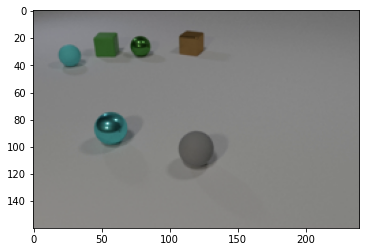

In [3]:
plt.imshow(iio.imread("Dataset_Student/train/video_0/image_21.png"))

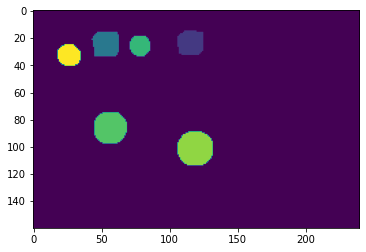

In [4]:
mask = np.load("Dataset_Student/train/video_0/mask.npy")
plt.imshow(mask[21])

In [5]:
mask[-1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [53]:
mask.shape

(22, 160, 240)

In [7]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 519 kB 34.0 MB/s eta 0:00:01


In [8]:
jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49)
jaccard(torch.Tensor(mask[0]), torch.Tensor(mask[0]))

tensor(0.1429)

# Install packages

In [9]:
# https://smp.readthedocs.io/en/latest/losses.html
!pip install -U segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 106 kB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 82.4 MB/s eta 0:00:01
     |████████████████████████████████| 549 kB 88.5 MB/s eta 0:00:01
     |████████████████████████████████| 224 kB 100.0 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c0a1318cbfd50fb52f3ea43b356541724e874f7d2aeea6c2b03f5acef6b944c0
  Stored in directory: /tmp/pip-ephem-wheel-cache-me1cfy5l/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=9cbb3e604d3ad7b9390d4f7836990618bb5c3980e692fa21f02ee699ec418f4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-me1cfy5l/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedm

In [10]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm.notebook import tqdm
import torch.optim as optim

from segmentation_models_pytorch.losses import JaccardLoss


# Create dataloader

In [11]:
# remove this code after utils.py is downloaded from github and just import from utils directly
# import utils as u


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image


def batch_cov(x):
    # data input of size (batch_size, num_samples, embed_size)
    b, n, m = x.size()

    # Flatten the tensor to size (b*n, m)
    flat_tensor = x.view(b*n, -1)

    # Compute the covariance matrix (b*n, b*n)
    cov_matrix = torch.matmul(flat_tensor, flat_tensor.transpose(1, 0))

    return cov_matrix

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    indices = torch.triu_indices(n, n, offset=1)
    flattened_tensor = x.flatten()
    off_diagonal_tensor = flattened_tensor[indices[0]*(n) + indices[1]]
    return off_diagonal_tensor

class MyDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.inputs)
        
    def __getitem__(self, idx):
        input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
        label_data = torch.tensor(self.labels[idx], dtype=torch.float32)
        return input_data, label_data

In [13]:
# separate inputs and outputs, for segmentation classification we don't have to group images as videos 
train_folder = "Dataset_Student/train/"

x_train = []
y_train = []

to_tensor = transforms.ToTensor()

list_video_paths = [train_folder + v for v in os.listdir(train_folder)]
for video_path in list_video_paths[:20]:
  y_train.append(list(np.load(f"{video_path}/mask.npy")))

  for img_path in [video_path + "/" + i for i in os.listdir(f"{video_path}") if "mask" not in i]:
    img = Image.open(img_path)
    
    img = to_tensor(img) #.unsqueeze(0)
    # print(img.shape)
    x_train.append(img)

x_train = torch.stack(x_train, dim=0)
print("Shape of x:", x_train.shape)

y_train = np.array(y_train)
print("Shape of y before:",y_train.shape)
dim1, dim2, dim3, dim4 = y_train.shape
y_train = y_train.reshape(dim1*dim2, dim3, dim4)
print("Shape of y after:", y_train.shape)

# batch size for training
batch_size = 16

# feed into dataloader
# train = u.MyDataset(x_train, x_train)
train = MyDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)

import gc
del x_train, y_train, train
gc.collect()

Shape of x: torch.Size([440, 3, 160, 240])
Shape of y before: (20, 22, 160, 240)
Shape of y after: (440, 160, 240)


675

In [15]:
val_folder = "Dataset_Student/val/"

x_val = []
y_val = []

to_tensor = transforms.ToTensor()

list_video_paths = [val_folder + v for v in os.listdir(val_folder)]
for video_path in list_video_paths[:20]:
  y_val.append(list(np.load(f"{video_path}/mask.npy")))

  for img_path in [video_path + "/" + i for i in os.listdir(f"{video_path}") if "mask" not in i]:
    img = Image.open(img_path)
    
    img = to_tensor(img) #.unsqueeze(0)
    # print(img.shape)
    x_val.append(img)

x_val = torch.stack(x_val, dim=0)
print("Shape of x:", x_val.shape) # batch_size * num_frames, num_channels, image_size 

y_val = np.array(y_val)
print("Shape of y before:",y_val.shape)
dim1, dim2, dim3, dim4 = y_val.shape
y_val = y_val.reshape(dim1*dim2, dim3, dim4)
print("Shape of y after:", y_val.shape)

val = MyDataset(x_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

del x_val, y_val, val
gc.collect()

Shape of x: torch.Size([440, 3, 160, 240])
Shape of y before: (20, 22, 160, 240)
Shape of y after: (440, 160, 240)


653

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# PatchEmbedding

Run PatchEmbedding without training just to get example data for running mask segmentation model

In [17]:
#https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/patch_embed.py

from typing import List, Optional, Callable
from enum import Enum
from itertools import repeat
import collections.abc

def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse

to_2tuple = _ntuple(2)

class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim, norm_layer:Optional[Callable] = None, flatten=True):
      # TODO
      super().__init__()
      image_size = to_2tuple(image_size)
      patch_size = to_2tuple(patch_size)
            
      self.image_size = image_size
      self.patch_size = patch_size
      self.grid_size = (image_size[0] // patch_size[0], image_size[1] // patch_size[1])
      self.num_patches = self.grid_size[0] * self.grid_size[1]
      self.flatten = flatten

      self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
      self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
      # TODO
      B, C, H, W = x.shape
      x = self.proj(x)
      x = x.flatten(2).transpose(1, 2)  # BCHW -> BNCu
      x = self.norm(x)
      
      # if we dont unsqueeze batch size is treated as number of channels since y is 2D not 3D. 
      x = torch.unsqueeze(x, dim=1)
      return x


In [20]:
image_size = (160, 240)
in_channels = 3 
patch_size = 40
embed_dim = 64

In [21]:
dummy_model = PatchEmbedding(image_size, patch_size, in_channels, embed_dim).to(device)

# random patches
input_tensor = torch.randn(100, 3, 160, 240).to(device) # batch_size, in_channels, image_size
print("Shape input_tensor:", input_tensor.shape)
output = dummy_model(input_tensor) 
print(output.shape) # batch_size, num_channels, patch_size, embed_dim

Shape input_tensor: torch.Size([100, 3, 160, 240])
torch.Size([100, 1, 24, 64])


# Mask Generation

In [72]:
class MaskGeneration(nn.Module):
    def __init__(self): 
      super().__init__()
     
      self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
      
      self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=49, kernel_size=3, padding=1, stride = 2), #48 classes (objects) + 1 background
          nn.BatchNorm2d(49),
          nn.ReLU(),
      )
      
    def forward(self, x, verbose=False):
      x1 = self.conv1(x)
      x2 = self.conv2(x1)
      conv_final = x2.view(x2.shape[0], 49, 160, 240)  # (N, C, H, W)      
      return conv_final


In [73]:
N_EPOCHS = 10

In [74]:
# from torchmetrics import Dice

model = MaskGeneration()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9) 
optimizer = optim.Adam(model.parameters(), lr=0.01)

criterion = JaccardLoss(mode ='multiclass')

model.train()

train_losses = []
validation_losses = []

pbar = tqdm(range(N_EPOCHS))
for i in pbar:
  total_train_loss = 0.0
  total_validation_loss = 0.0
 
  for batch in tqdm(train_dataloader, leave=False):
    optimizer.zero_grad()

    data = batch[0].to(device)  # batch_size, num_channels = 3, image_size
    target = batch[1].to(device)    # batch_size, num_channels = 49, image_size
    target = target.to(torch.int64)
    
    # Let JaccardLoss perform one hot encode on target otherwise run out of memory
    # target = F.one_hot(target.to(torch.int64), num_classes = 49).permute(0,3,1,2).contiguous() 
    
    patch_embeddings = dummy_model(data)
    
    preds = model(patch_embeddings)  # 16, 49, 160, 240
    
    loss = criterion(preds, target)
    
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()

  with torch.no_grad():
    for batch in val_dataloader:
      data = batch[0].to(device)  # batch_size, num_channels = 3, image_size
      target = batch[1].to(device)    # batch_size, num_channels = 49, image_size
      target = target.to(torch.int64)

      #input to the model should be patch_embeddings learned during pretraining
      patch_embeddings = dummy_model(data)
      preds = model(patch_embeddings)
      loss = criterion(preds, target)
      total_validation_loss += loss.item()

  mean_train_loss = total_train_loss / len(train_dataloader)
  train_losses.append(mean_train_loss)
  
  mean_validation_loss = total_validation_loss / len(val_dataloader)
  validation_losses.append(mean_validation_loss)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss})



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

<ipython-input-5-da492d27b881>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [78]:
train_losses

[0.155069979972073,
 0.15436384587415627,
 0.15363652232502187,
 0.15232666608478343,
 0.15076414788407938,
 0.1493213770112821,
 0.14751499066395418,
 0.14611929655075073,
 0.14512726770980017,
 0.14412154576608113]

In [79]:
validation_losses

[0.17790518275329045,
 0.17721651175192424,
 0.17622529262942926,
 0.1746882934655462,
 0.17326845335108892,
 0.17177438735961914,
 0.16990971645074232,
 0.16899386713547365,
 0.16781180830938475,
 0.16717687941023282]

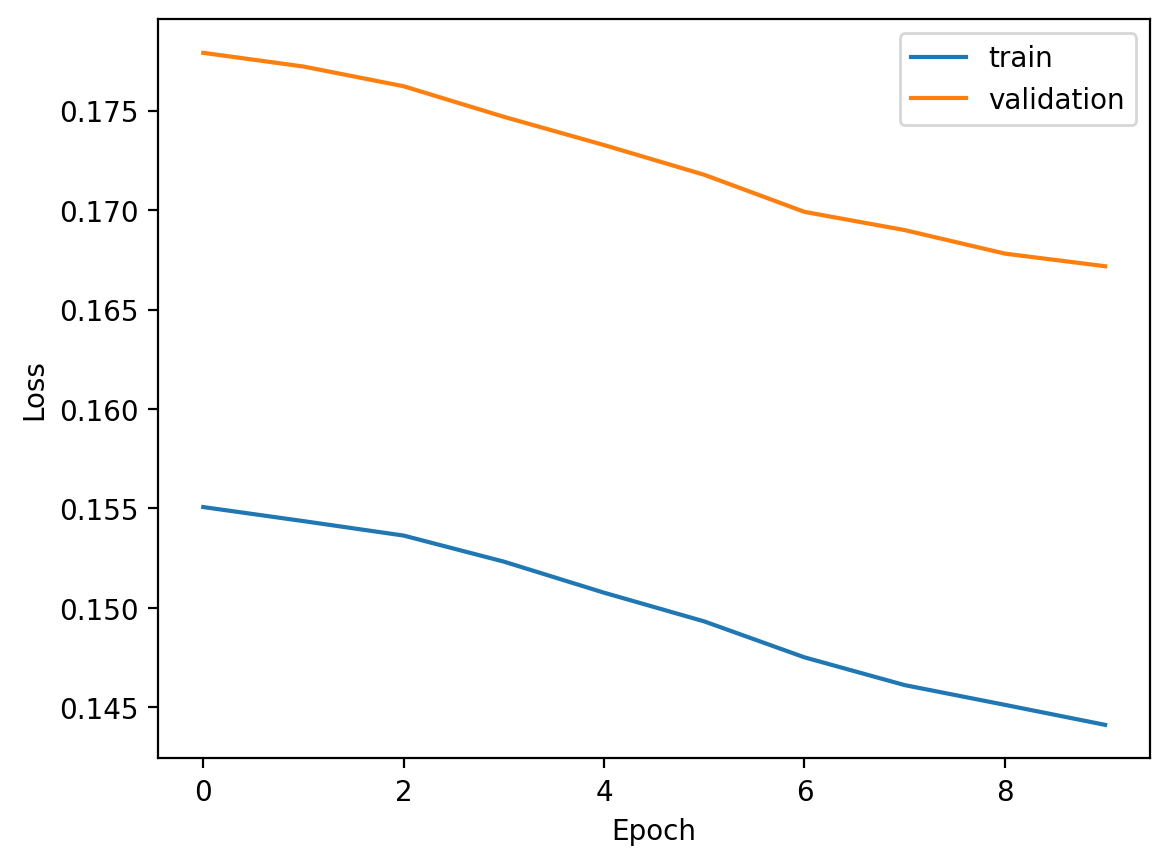

In [83]:
plt.figure(dpi=200)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
